# Iceberg migration in the Barents Sea
## dataset visualization

#### Project for [AT-327](https://www.unis.no/courses/at-327-arctic-offshore-engineering/)

###### by Michał Jan Odorczuk and Hélène Chanrion

### Necessary import and notebook preparation

In [1]:
from IPython.display import clear_output
%pip install netCDF4
import netCDF4 as nc
%pip install matplotlib
from matplotlib import pyplot as plt
%pip install numpy
import numpy as np
from matplotlib import rcParams
%pip install scipy
from scipy import signal
from scipy import interpolate
%pip install pandas
import pandas as pd
import re
%pip install imageio
import imageio
from datetime import datetime, timedelta, date
clear_output()

plt.show()
rcParams['figure.figsize'] = [16, 12]

### Domain setting

In [2]:
msperdeg = 111139
LONG = 25
LATI = 73.5

LATMARGIN = 0.9

epsilon = LATMARGIN * np.pi / (180 * np.sin((90 - LATI) * np.pi / 180))

LONGE = LONG + epsilon * 180 / np.pi
LONGW = LONG - epsilon * 180 / np.pi
LATIN = LATI + LATMARGIN
LATIS = LATI - LATMARGIN

### Bathymetry data

###### source: [IBCAO](https://www.gebco.net/data_and_products/gridded_bathymetry_data/arctic_ocean/), trimmed to the area of interest

In [3]:
fn = "./datasets/IBCAO_v4_2_200m_trimmed.nc"
ds = nc.Dataset(fn)
zs = np.array(ds['z'])
xs = np.array(ds['x'])
ys = np.array(ds['y'])
depthInterpolator = interpolate.RegularGridInterpolator((ys, xs), zs)

def getDepth(longs, lats):
    msperdeg = 111139
    r = (90 - lats) * msperdeg
    alpha = longs * np.pi / 180
    ys, xs = -r * np.cos(alpha), r * np.sin(alpha)
    return depthInterpolator((ys, xs))

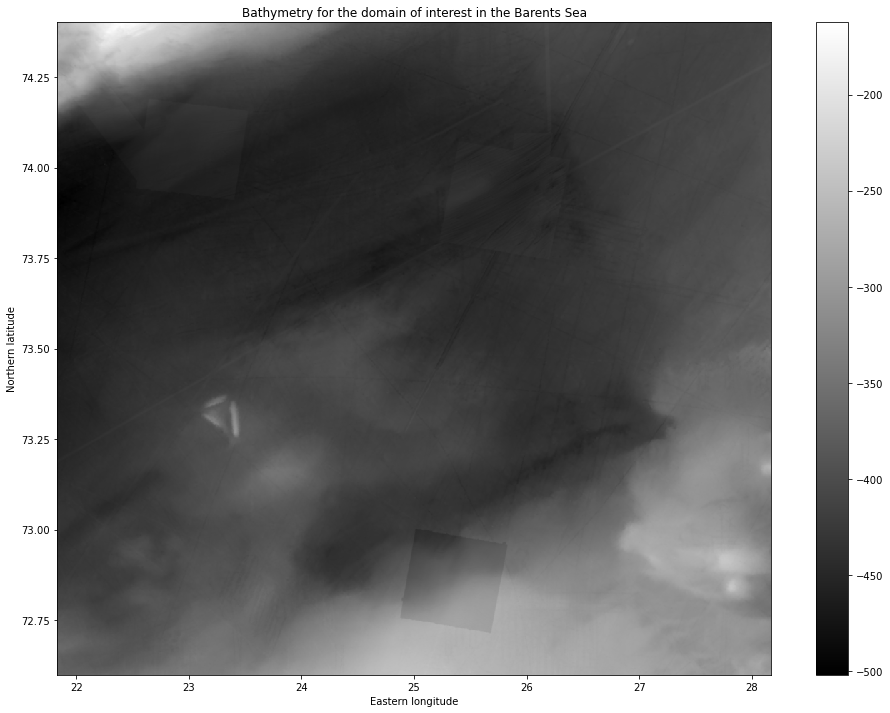

In [4]:
fig, ax = plt.subplots()
longs = np.linspace(LONGW, LONGE, 1000)
lats = np.linspace(LATIS, LATIN, 1000)
X, Y = np.meshgrid(longs, lats)

zs = getDepth(X, Y)

p = ax.pcolor(X, Y, zs, cmap='gray')
cb = fig.colorbar(p, ax=ax)
plt.title("Bathymetry for the domain of interest in the Barents Sea")
ax.set_xlabel("Eastern longitude")
ax.set_ylabel("Northern latitude");

### Sea surface velocity

###### source: [ERA-5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-level-global?tab=overview), trimmed to the area of interest

In [5]:
ds = nc.Dataset(f"./datasets/ERA-5_trimmed.nc")
longs, latis = np.array(ds["longitude"]), np.array(ds["latitude"])
lati_mask = (latis<LATIN)&(latis>LATIS)
long_mask = (longs>LONGW)&(longs<LONGE)
k = 0
dir = 'gifs/tmp'
dates = np.array(ds['time'])
t0 = date(1950, 1, 1)
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))
for i in range(dates.shape[0]):
    vgos = np.array(ds["vgos"][i])[lati_mask,:][:,long_mask]
    ugos = np.array(ds["ugos"][i])[lati_mask,:][:,long_mask]
    xs, ys = latis[lati_mask], longs[long_mask]
    Y, X = np.meshgrid(ys, xs)
    t = t0 + timedelta(days=int(dates[i]))
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(t)
    axs[0].pcolor(Y, X, vgos)
    axs[0].set_title("Northward sea surface velocity")
    axs[1].pcolor(Y, X, ugos)
    axs[1].set_title("Eastward sea surface velocity")
    fig.savefig(f'gifs/tmp/{k}.png')
    plt.clf()
    plt.close()
    k += 1

with imageio.get_writer('gifs/ssvERA5.gif', mode='I') as writer:
    for filename in [f'gifs/tmp/{i}.png' for i in range(k)]:
        image = imageio.imread(filename)
        writer.append_data(image)
dir = 'gifs/tmp'
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

## Wind and waves

###### source: [ERA-5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview)

In [8]:
ds = nc.Dataset("./datasets/adaptor.mars.internal-1670349740.5115466-316-8-053b4649-1c66-408f-a6d6-dab0ca44fd2a.nc")

In [9]:

longs = np.array(ds["longitude"])
latis = np.array(ds["latitude"])
longs2, latis2 = longs * 2, (latis - max(latis)) * 2 + max(latis)
time = np.array(ds["time"])
long_mask = (longs>LONGW)&(longs<LONGE)
lati_mask = (latis>LATIS)&(latis<LATIN)


long_mask2 = (longs2>LONGW)&(longs2<LONGE)
lati_mask2 = (latis2>LATIS)&(latis2<LATIN)
u = ds["u10"][:,0,:,:]
v = ds["v10"][:,0,:,:]
mwd = ds["mwd"][:,0,:,:]
swh = ds["swh"][:,0,:,:]

dir = 'gifs/tmp'
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

k = 0
X, Y = np.meshgrid(longs[long_mask], latis[lati_mask])
X2, Y2 = np.meshgrid(longs2[long_mask2], latis2[lati_mask2])
t0 = date(1900, 1, 1)

for i in range(time.shape[0]):
    t = t0 + timedelta(hours=int(time[i]))
    fig, axs = plt.subplots(2, 2)
    fig.suptitle(f"{t}")
    p = axs[0,0].pcolor(X, Y, u[i,:,:][lati_mask,:][:,long_mask])
    axs[0,0].set_title("Eastward wind velocity")

    p = axs[0,1].pcolor(X, Y, v[i,:,:][lati_mask,:][:,long_mask])
    axs[0,1].set_title("Northward wind velocity")

    p = axs[1,0].pcolor(X2, Y2, mwd[i,:,:][lati_mask2,:][:,long_mask2])
    axs[1,0].set_title("Mean wave direction")

    p = axs[1,1].pcolor(X2, Y2, swh[i,:,:][lati_mask2,:][:,long_mask2])
    axs[1,1].set_title("Significant wave height")

    fig.savefig(f'gifs/tmp/{k}.png')
    plt.clf()
    plt.close()
    k += 1

with imageio.get_writer('gifs/wind.gif', mode='I') as writer:
    for filename in [f'gifs/tmp/{i}.png' for i in range(k)]:
        image = imageio.imread(filename)
        writer.append_data(image)
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

## Ice, salinity and temperature

###### source: [ORAS5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-oras5?tab=overview)

In [ ]:
ds = nc.Dataset("./datasets/ORAS5_trimmed.nc")
from netCDF4 import num2date

latitude
longitude
time
ithic
mivel
zivel
icon
sss
sst


In [5]:
from netCDF4 import num2date

dir = 'gifs/tmp'
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

k = 0
dates = num2date(ds['time'][:], ds['time'].units)


longs = np.array(ds["longitude"])
latis = np.array(ds["latitude"])

dir = 'gifs/tmp'
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

X, Y = np.meshgrid(longs, latis)
names = [name for name in ds.variables if name != 'time' and name != 'longitude' and name != 'latitude']

for i in range(dates.shape[0]):
    fig, axs = plt.subplots(2, 3)
    plots = [axs[i,j] for i in range(2) for j in range(3)]
    fig.suptitle(dates[i])
    for j in range(6):
        p = plots[j].pcolor(X, Y, ds[names[j]][i,:,:].T)
        plots[j].set_title(ds[names[j]].long_name)
        plots[j].set_ylabel('North latitude')
        plots[j].set_xlabel('East longitude')

    fig.savefig(f'gifs/tmp/{k}.png')
    plt.clf()
    plt.close()
    k += 1

with imageio.get_writer('gifs/ORAS5.gif', mode='I') as writer:
    for filename in [f'gifs/tmp/{i}.png' for i in range(k)]:
        image = imageio.imread(filename)
        writer.append_data(image)
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

IndexError: time not found in /